In this notebook, I will look at the positional adjustments of defining sources in the VLBI solutions in order to understand what happened with the NNR constraint.

The solutions are listed below.

*NB: This list would be updated frequently.*

| Label | A priori position | Defining source ensemble |  Position of defining sources | NNR constraint strength (rad) |
|---|---|---|---|---|
| opa-icrf250 | ICRF3 S/X | GCRF250 | Adjusted | $10^{-10}$ |

In [1]:
from astropy.table import Table, Column, join
from astropy.time import Time
import astropy.units as u
# import bottleneck as bn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

Read the two a priori catalog which is the `ICRF3 S/X` and `Gaia DR2` to get the radio source positions.

In [2]:
# Read ICRF3 S/X catalog
from my_progs.catalog.read_icrf import read_icrf3
icrf3 = read_icrf3(wv="sx")

# # Read Gaia DR2 IERS quasar data
from my_progs.catalog.read_gaia import read_dr2_iers
gdr2 = read_dr2_iers()

# Solution opa2019a

The a priori position for this solution is the ICRf3 S/X catalog.

For the defining sources, all 303 ICRF3 defining sources were used.

Create a sub-table from the ICRF3 S/X catalog for the 303 defining sources.

In [3]:
# Create a sub-table for 303 ICRF3 defining sources
mask303 = icrf3["type"] == "D"
icrf3def = icrf3[mask303]

In [4]:
# opa2019a
from my_progs.vlbi.read_sou import read_sou
from my_progs.catalog.pos_diff import radio_cat_diff_calc

opa2019a_sou = read_sou("../data/opa2019a/opa2019a.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(opa2019a_sou, icrf3def, sou_name="iers_name")

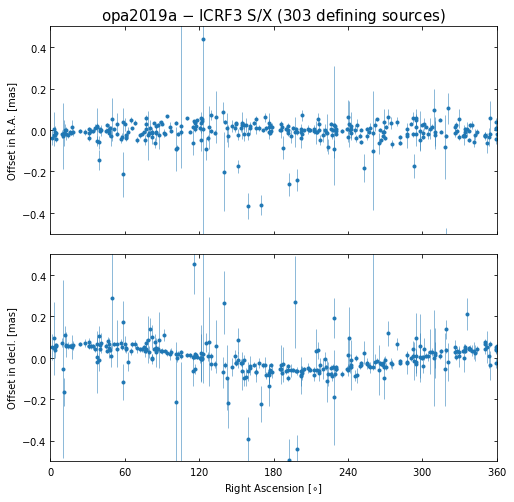

In [5]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a $-$ ICRF3 S/X (303 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

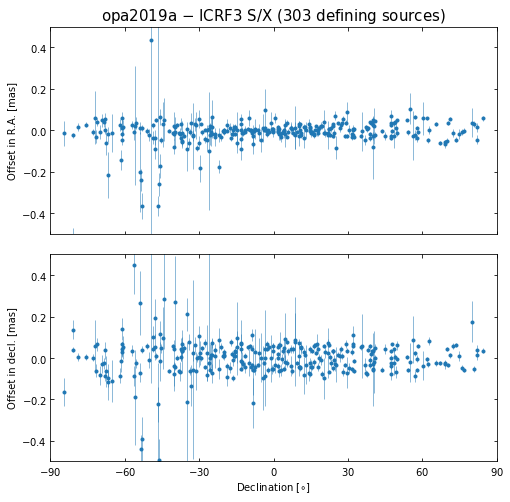

In [6]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a $-$ ICRF3 S/X (303 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [7]:
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting

# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None") #, fit_type="rotation")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))



# print("Estimates (%6d sources)\n"
#       "----------------------------------------------"
#       "----------------------------------------------\n"
#       "                 Rotation [uas]               \n"
#       "           x             y             z      \n"
#       "----------------------------------------------"
#       "----------------------------------------------\n"
#       "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
#       "----------------------------------------------"
#       "----------------------------------------------\n" %
#       (dra.size,
#        par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   301 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
      +26 +/-   2   -52 +/-   2    -3 +/-   2       -1 +/-   2    -5 +/-   2    +3 +/-   2
--------------------------------------------------------------------------------------------



# Solution opa-icrf250

In [8]:
# List of 250 common defining sources between Gaia DR2 and ICRF3 S/X
def250 = Table.read("../logs/def250.list", format="ascii.csv")

# ICRF3 S/X band position for these 250 sources
icrf250 = join(icrf3, def250, keys="iers_name")

In [9]:
opa2019a250 = read_sou("../data/icrf250/icrf250.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(opa2019a250, icrf250, sou_name="iers_name")

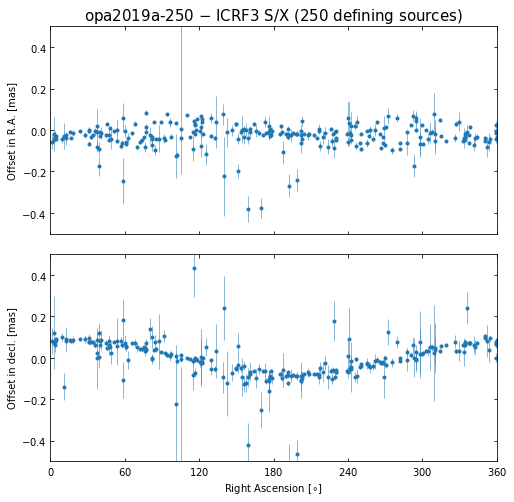

In [10]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a-250 $-$ ICRF3 S/X (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

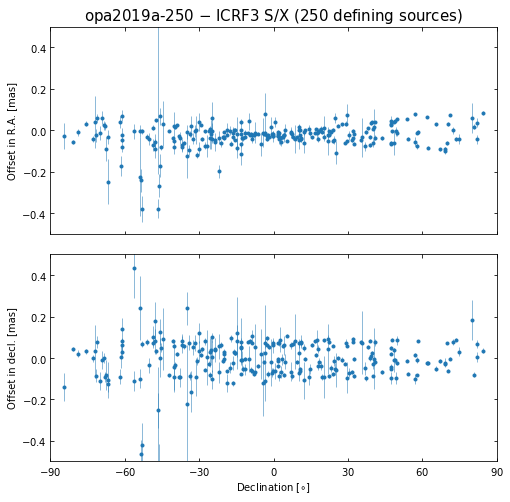

In [11]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a-250 $-$ ICRF3 S/X (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [12]:
# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   249 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
      +20 +/-   2   -80 +/-   2   -25 +/-   2       -1 +/-   2    -5 +/-   2    +3 +/-   2
--------------------------------------------------------------------------------------------



# Solution opa2019a-fix

In [13]:
# opa2019a-fix
opa2019afix_sou = read_sou("../data/icrf3-fix/icrf3-fix.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(opa2019afix_sou, icrf3def, sou_name="iers_name")

In [14]:
souoft

iers_name,ra_err_1,dec_err_1,pos_err_1,ra,dec,ra_err_2,dec_err_2,pos_err_2,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_ra,nor_dec,nor_sep
,mas,mas,mas,deg,deg,mas,mas,,mas,mas,mas,mas,,mas,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0007+106,0.014529319893684424,0.0167,0.016850365493161556,2.6291912672083333,10.974862305027777,0.03607787203439982,0.0385,0.039351348789675895,0.03813946316930778,0.032299999475071665,0.038893623990360456,0.04196593856927306,-0.00014709525428891447,0.04997908179361256,0.9806096541366373,0.769671799946858,1.3053216513116848
0046+316,0.025453375600050395,0.0438,0.04398593449774427,12.196422829166666,31.956967936166667,0.04607060984149744,0.06839999999999999,0.06905915767093863,0.05319755669907664,0.03880000321032639,0.05263435589617034,0.0812219182240853,-0.0006346326180915061,0.06584390850999668,1.0107002506883014,0.47770360585771976,1.1935051979441853
0305+039,0.030920241402134396,0.0456,0.04560001940548837,47.10926583354166,4.110916883555555,0.054160293811677106,0.0735,0.07350968739773868,0.016906415375195303,0.04460000049277823,0.06236504432880214,0.08649630049892307,6.0723608775795516e-05,0.04769682300525328,0.27108800381927073,0.5156289949456685,0.5798772096920273
1222+131,0.03636048344359375,0.0931,0.09313428142140753,186.26559724674996,12.886983114944444,0.05995093115328805,0.13799999999999998,0.13807215851349455,-0.057757492298733955,0.09540000149854676,0.07011561097500427,0.166468044981612,-0.0007717839368435257,0.11152169386518945,-0.8237465451071103,0.5730829692214179,0.9740126657920573
1245-457,0.05328372588574678,0.1006,0.10102940475208377,192.11872979462498,-45.99643879933333,0.09597323042602826,0.2098,0.21068704904521549,0.09889107483973347,-1.151800012166859,0.1097725667126123,0.23267230174646913,0.004421010636226005,1.1560375048892377,0.9008723928140727,-4.95030995748654,5.262191676381062
1730-130,0.005162482625513292,0.0094,0.009409354774803662,263.261274121125,-13.080430058861111,0.031121003748560142,0.033699999999999994,0.0337166368839981,0.041348724368328274,0.09570000472081118,0.03154628506142397,0.03498642593921247,-1.0439130630648747e-05,0.10425069740990353,1.3107319701136888,2.7353466995195834,3.0444689853046416
2017+745,0.022035091338574963,0.0212,0.022253130686519948,304.30449706904164,74.67999997266668,0.045219495015335995,0.044399999999999995,0.046201677088491745,0.09547220297120665,0.025199989295288102,0.05030256434558121,0.04920162598939185,0.00014208853553145987,0.09874199208370223,1.8979589651793434,0.5121779776286532,1.9404558094104292


Even we tried to fix position for all 303 defining sources, Calc/Solve still gives adjustments to positions of 7 radio sources.

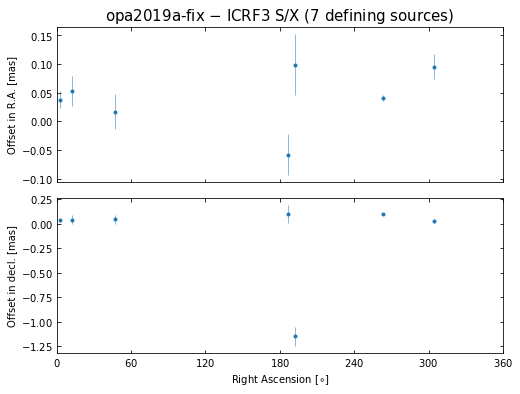

In [15]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
# ax0.set_ylim([-0.5, 0.5])
# ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a-fix $-$ ICRF3 S/X (7 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

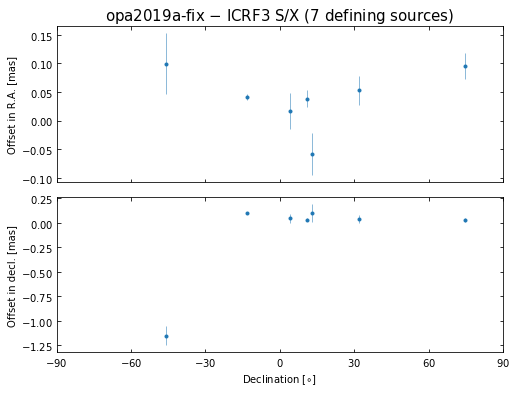

In [16]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])

ax0.set_title("opa2019a-fix $-$ ICRF3 S/X (7 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

# Solution icrf250-fix

In [17]:
# icrf250-fix
icrf250fix_sou = read_sou("../data/icrf250-fix/icrf250-fix.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(icrf250fix_sou, icrf3def, sou_name="iers_name")

In [18]:
souoft

iers_name,ra_err_1,dec_err_1,pos_err_1,ra,dec,ra_err_2,dec_err_2,pos_err_2,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_ra,nor_dec,nor_sep
,mas,mas,mas,deg,deg,mas,mas,,mas,mas,mas,mas,,mas,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0007+106,0.01452931989368579,0.0167,0.01685036549316166,2.6291912672083333,10.974862305027777,0.03607787203439982,0.0385,0.039351348789675895,0.037844949903842504,0.03220000266423994,0.03889362399036097,0.04196593856927306,-0.00014709525428891626,0.049689842068589916,0.9730373778802829,0.7672889910727835,1.2976044302670002
0038-326,0.15970734959510727,0.4323,0.4324720259385009,10.12772855095833,-32.422313846277774,0.23462292710539626,0.6290999999999999,0.6292098313310017,0.11458918191890745,0.08499998784827766,0.28382099189136434,0.7633152035692724,0.011765405273380727,0.1426733280857071,0.4037375148162675,0.11135634067134592,0.41355222268811237
0046+316,0.025453375600050395,0.0438,0.04398593449774427,12.196422829166666,31.956967936166667,0.04607060984149744,0.06839999999999999,0.06905915767093863,0.053070291166959674,0.03880000321032639,0.05263435589617034,0.0812219182240853,-0.0006346326180915061,0.06574112908725568,1.00828233315231,0.47770360585771976,1.1912649823959394
0054+161,0.012277933089653336,0.0134,0.013408897371530806,14.230393037291666,16.420372476055558,0.034243922758834894,0.036199999999999996,0.03623722002667756,0.03179792937351839,0.01989999844909107,0.03637848109620651,0.03860051813123756,-1.6829802206334544e-05,0.03751157488985354,0.8740862294229823,0.5155370811716371,1.0201746177806348
0107-610,0.03197347832431729,0.0559,0.055903057202749726,17.314479996124998,-60.83012781075001,0.06521419807763962,0.10759999999999999,0.10784210368185715,0.05921916800773867,0.15880000034940164,0.07263053729021425,0.12125415456799819,-0.0005934972562678755,0.1694825948895601,0.8153480645628856,1.309645850199286,1.5922946536865765
0302+625,0.015539160822474817,0.0182,0.018202445029381918,46.677748130874996,62.71722893527778,0.03651015219316818,0.03919999999999999,0.0392208465217247,-0.013751453302594934,-0.013899997952648844,0.03967942454515992,0.04321897731321276,2.114746123413448e-05,0.019552810821390647,-0.34656382899263416,-0.3216179284371771,0.4699246520678495
0305+039,0.030920241402148402,0.0456,0.04560001940548837,47.10926583354166,4.110916883555555,0.054160293811677106,0.0735,0.07350968739773868,0.01735525284241798,0.043300000385215746,0.062365044328809086,0.08649630049892307,6.072360877579615e-05,0.046648631647497885,0.2782849435801787,0.5005994491724517,0.5700413260943678
0316-444,0.1021653201658171,0.2447,0.247853590859561,49.49033108974999,-44.23810089772223,0.1517434415721964,0.37889999999999996,0.3846626192976763,0.15077625653498908,0.42020001558285,0.18293120210822017,0.4510468933492392,-0.03234664957544224,0.4464320022472988,0.8242238327707017,0.9316104861351857,1.5936101479579086


Even we tried to fix position for all 250 defining sources, Calc/Solve still gives adjustments to positions of 57 radio sources.

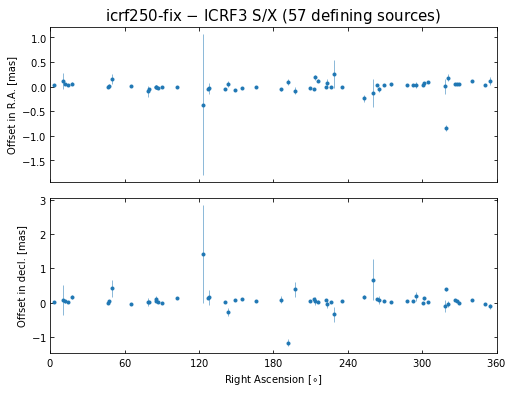

In [19]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])

ax0.set_title("icrf250-fix $-$ ICRF3 S/X (57 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

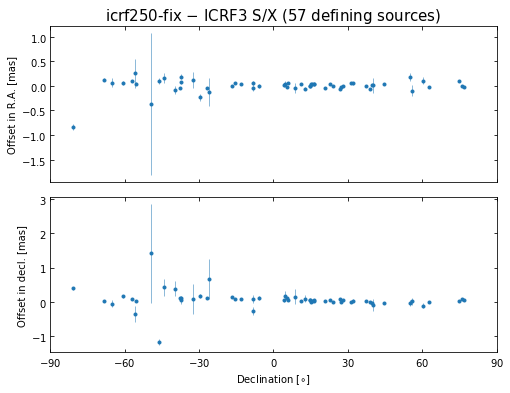

In [20]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 6), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])

ax0.set_title("icrf250-fix $-$ ICRF3 S/X (57 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

# Solution opa2019a-wgt

In [21]:
# opa2019a-wgt
opa2019awgt_sou = read_sou("../data/icrf3-nnr-wgt/icrf3-nnr-wgt.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(opa2019awgt_sou, icrf3def, sou_name="iers_name")

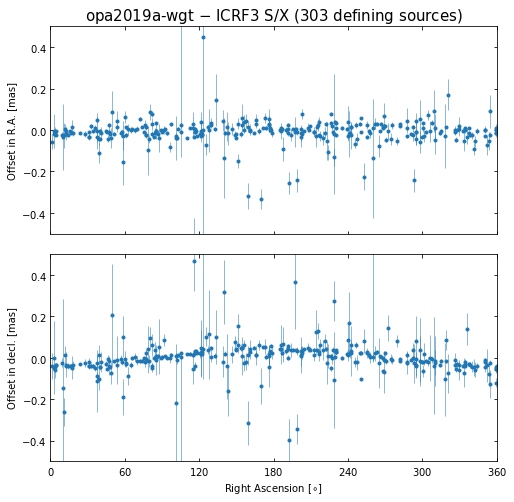

In [22]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a-wgt $-$ ICRF3 S/X (303 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

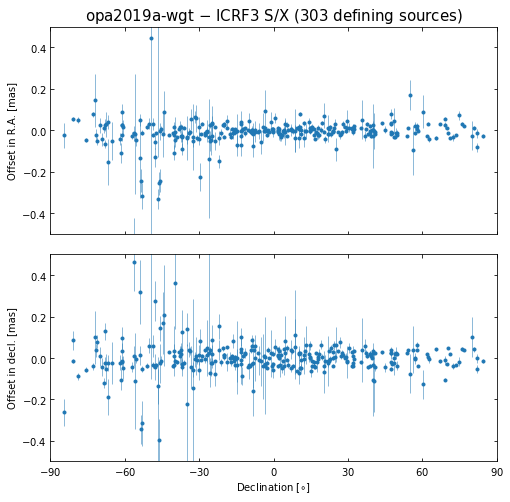

In [23]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-0.5, 0.5])
ax1.set_ylim([-0.5, 0.5])

ax0.set_title("opa2019a-wgt $-$ ICRF3 S/X (303 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [24]:
# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   301 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
       -1 +/-   2   +41 +/-   2    -3 +/-   2       -1 +/-   2    -7 +/-   2    +1 +/-   2
--------------------------------------------------------------------------------------------



# Solution gcrf250

In [25]:
# Gaia position for these 250 sources
gcrf250 = join(gdr2, def250, keys="iers_name")

# gcrf250
gcrf250_sou = read_sou("../data/gcrf-a1u/gcrf-a1u.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(gcrf250_sou, gcrf250, sou_name="iers_name")

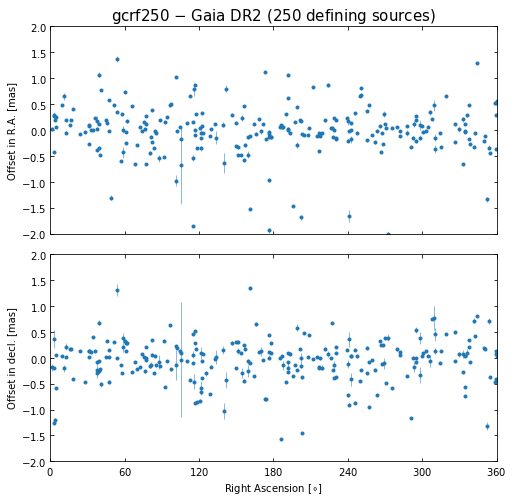

In [26]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250 $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

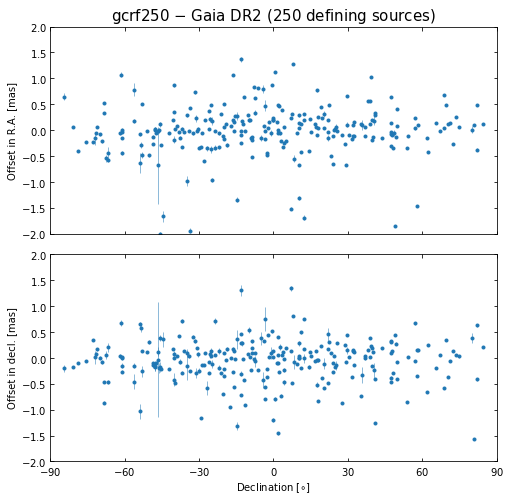

In [27]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250 $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [28]:
# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   249 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
      +49 +/-  32   -40 +/-  29    +2 +/-  37      -59 +/-  30   +44 +/-  32   +66 +/-  35
--------------------------------------------------------------------------------------------



# Solution gcrf250-nnr200

In [29]:
# gcrf250
gcrf250_nnr200_sou = read_sou("../data/gcrf-a2u/gcrf-a2u.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(gcrf250_nnr200_sou, gcrf250, sou_name="iers_name")

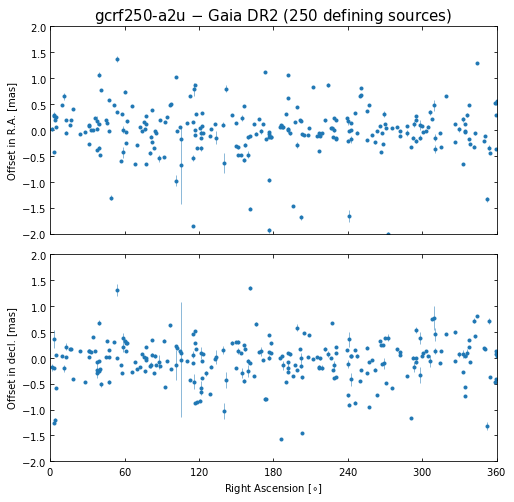

In [30]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250-a2u $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

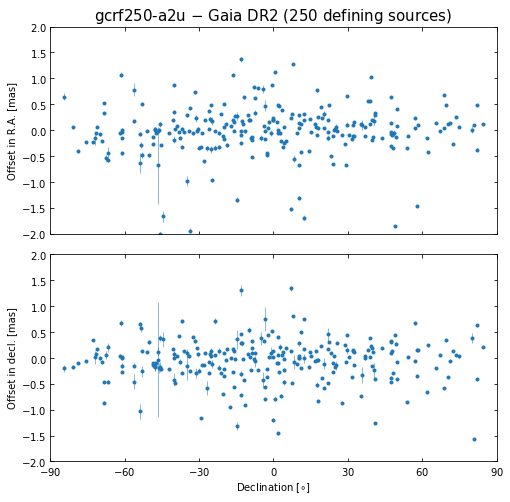

In [31]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250-a2u $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [32]:
# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   249 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
      +49 +/-  32   -40 +/-  29    +2 +/-  37      -59 +/-  30   +44 +/-  32   +66 +/-  35
--------------------------------------------------------------------------------------------



# Solution gcrf250-fix

In [33]:
# gcrf250wgt
gcrf250wgt_sou = read_sou("../data/gcrf-a1u-fix/gcrf-a1u-fix.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(gcrf250wgt_sou, gcrf250, sou_name="iers_name")

In [34]:
souoft

iers_name,ra_err_1,dec_err_1,pos_err_1,ra,ra_err_2,dec,dec_err_2,pos_err_2,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_ra,nor_dec,nor_sep
,mas,mas,mas,deg,mas,deg,mas,mas,mas,mas,mas,mas,,mas,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0007+106,0.014529319895266263,0.0167,0.016850365493280395,2.6291913864114305,0.07220077482853457,10.974862370062839,0.06707566002756404,0.0875928007083494,-0.478712767911125,-0.31762621972575283,0.07364817053029717,0.06912332578900811,0.002774577024223797,0.5745018099348363,-6.499995376181049,-4.595065646801695,6.620095409559671
0305+039,0.03092024140188444,0.0456,0.04560001940548837,47.10926720406456,0.3551479946834422,4.110917013835781,0.37852766876446053,0.3881075225274661,-4.905777978083036,-0.4012088133720226,0.35649145776024016,0.3812644174588774,0.01341464012916254,4.922156649495409,-13.761277784620685,-1.052311191393297,13.764710387671592
1245-457,0.05328372605545773,0.1006,0.1010294047558212,192.11872971155515,0.08620004543541572,-45.99643887949811,0.08658309964770766,0.09018502629575553,0.012262564343099162,-0.2287068070927489,0.10133905118670097,0.1327290214859014,0.00012971060620738898,0.22903531189497506,0.12100532025415701,-1.7231107751144112,1.728598373745675
1730-130,0.005162482625249278,0.0094,0.009409354774802299,263.2612741427579,0.1809134614789193,-13.080429848887354,0.1498652233371083,0.1894720299677197,-0.03962295403935831,-0.7056055260079573,0.1809871038807473,0.15015973217171558,0.006530519583544649,0.7067171547512988,-0.21892694667055362,-4.699032928488846,4.791680843135345
2017+745,0.022035091424094662,0.0212,0.022253130757836737,304.30449701819964,0.10083833058669896,74.67999998020957,0.11908825449960161,0.11968505642780107,-0.05864626188045371,-0.2212544643498404,0.103217799674187,0.12096054050706737,0.0007906006099047138,0.22889500218940026,-0.5681797332008051,-1.8291457976488883,1.8844685665737595


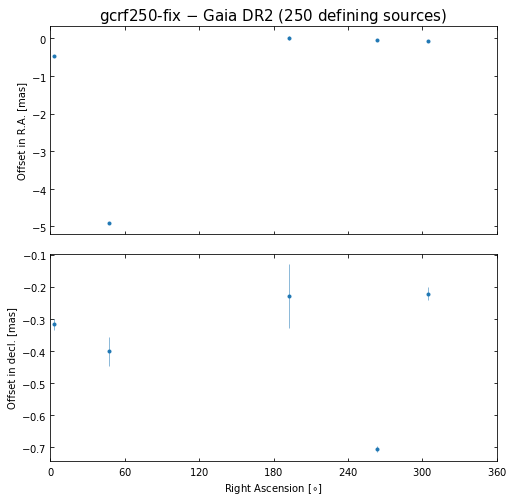

In [35]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])

ax0.set_title("gcrf250-fix $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

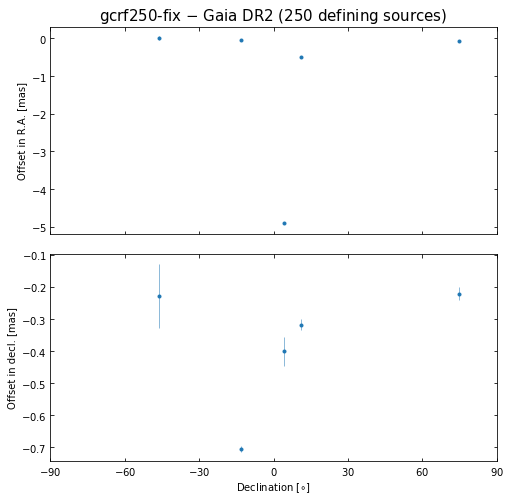

In [36]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
# ax0.set_ylim([-2, 2])
# ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250-fix $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

# Solution gcrf250-fix-nnr200

In [37]:
# gcrf250wgt
gcrf250_fix_nnr200_sou = read_sou("../data/gcrf-a2u-fix/gcrf-a2u-fix.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(gcrf250_fix_nnr200_sou, gcrf250, sou_name="iers_name")

In [38]:
souoft

iers_name,ra_err_1,dec_err_1,pos_err_1,ra,ra_err_2,dec,dec_err_2,pos_err_2,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_ra,nor_dec,nor_sep
,mas,mas,mas,deg,mas,deg,mas,mas,mas,mas,mas,mas,,mas,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0007+106,0.014529319895266263,0.0167,0.016850365493280395,2.6291913864114305,0.07220077482853457,10.974862370062839,0.06707566002756404,0.0875928007083494,-0.478712767911125,-0.31762621972575283,0.07364817053029717,0.06912332578900811,0.002774577024223797,0.5745018099348363,-6.499995376181049,-4.595065646801695,6.620095409559671
0305+039,0.03092024140188444,0.0456,0.04560001940548837,47.10926720406456,0.3551479946834422,4.110917013835781,0.37852766876446053,0.3881075225274661,-4.905777978083036,-0.4012088133720226,0.35649145776024016,0.3812644174588774,0.01341464012916254,4.922156649495409,-13.761277784620685,-1.052311191393297,13.764710387671592
1245-457,0.05328372605545773,0.1006,0.1010294047558212,192.11872971155515,0.08620004543541572,-45.99643887949811,0.08658309964770766,0.09018502629575553,0.012262564343099162,-0.2287068070927489,0.10133905118670097,0.1327290214859014,0.00012971060620738898,0.22903531189497506,0.12100532025415701,-1.7231107751144112,1.728598373745675
1730-130,0.005162482625249278,0.0094,0.009409354774802299,263.2612741427579,0.1809134614789193,-13.080429848887354,0.1498652233371083,0.1894720299677197,-0.03962295403935831,-0.7056055260079573,0.1809871038807473,0.15015973217171558,0.006530519583544649,0.7067171547512988,-0.21892694667055362,-4.699032928488846,4.791680843135345
2017+745,0.022035091424094662,0.0212,0.022253130757836737,304.30449701819964,0.10083833058669896,74.67999998020957,0.11908825449960161,0.11968505642780107,-0.05864626188045371,-0.2212544643498404,0.103217799674187,0.12096054050706737,0.0007906006099047138,0.22889500218940026,-0.5681797332008051,-1.8291457976488883,1.8844685665737595


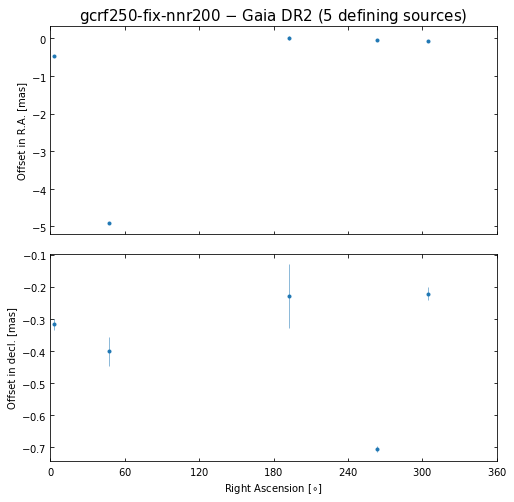

In [39]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])

ax0.set_title("gcrf250-fix-nnr200 $-$ Gaia DR2 (5 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

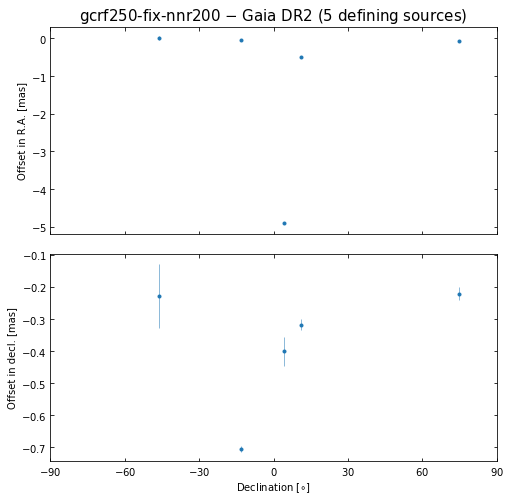

In [40]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])

ax0.set_title("gcrf250-fix-nnr200 $-$ Gaia DR2 (5 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

# Solution gcrf250-wgt

In [41]:
# gcrf250wgt
gcrf250wgt_sou = read_sou("../data/gcrf-a1w/gcrf-a1w.sou")

# Calculate the positional difference
souoft = radio_cat_diff_calc(gcrf250wgt_sou, gcrf250, sou_name="iers_name")

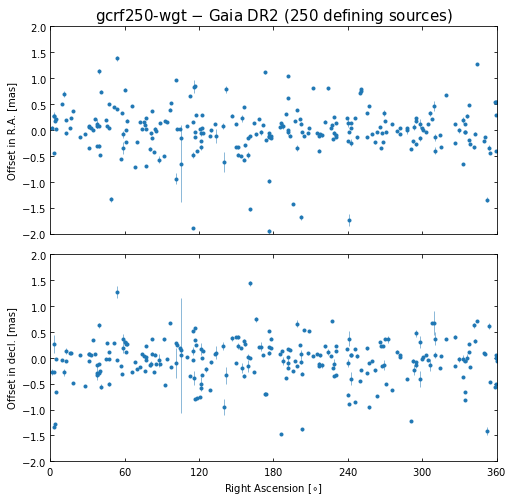

In [42]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["ra"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["ra"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Right Ascension [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(0, 361, 60))

ax0.set_xlim([0, 360])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250-wgt $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

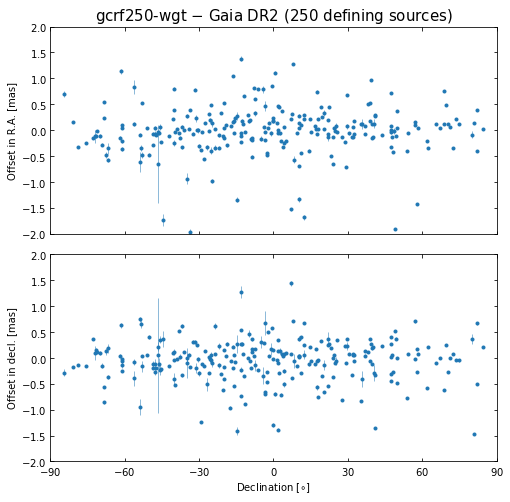

In [43]:
fig, (ax0, ax1) = plt.subplots(figsize=(8, 8), nrows=2, sharex=True)

ax0.errorbar(souoft["dec"], souoft["dra"], yerr=souoft["ra_err_1"], fmt=".", elinewidth=0.5)
ax1.errorbar(souoft["dec"], souoft["ddec"], yerr=souoft["dec_err_1"], fmt=".", elinewidth=0.5)

ax0.set_ylabel("Offset in R.A. [mas]")

ax1.set_xlabel("Declination [$\circ$]")
ax1.set_ylabel("Offset in decl. [mas]")

ax1.set_xticks(np.arange(-90, 91, 30))

ax0.set_xlim([-90, 90])
ax0.set_ylim([-2, 2])
ax1.set_ylim([-2, 2])

ax0.set_title("gcrf250-wgt $-$ Gaia DR2 (250 defining sources)", fontsize=15)

ax0.xaxis.set_ticks_position("both")
ax0.yaxis.set_ticks_position("both")
ax1.xaxis.set_ticks_position("both")
ax1.yaxis.set_ticks_position("both")

plt.subplots_adjust(hspace=0.1)

In [44]:
# Transform columns into np.array
dra = np.array(souoft["dra"])
ddec = np.array(souoft["ddec"])
dra_err = np.array(souoft["dra_err"])
ddec_err = np.array(souoft["ddec_err"])
ra_rad = np.array(souoft["ra"].to(u.radian))
dec_rad = np.array(souoft["dec"].to(u.radian))
dra_ddec_cov = np.array(souoft["dra_ddec_cov"])

# Transformation parameters
par, sig, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
#     cov=dra_ddec_cov, elim_flag="None")
         elim_flag="None")

# mas -> uas
par = par * 1.e3
sig = sig * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "                 Rotation [uas]                  "
      "                 Glide [uas]               \n"
      "           x             y             z     "
      "           x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f"
      "     %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size,
       par[3], sig[3], par[4], sig[4], par[5], sig[5],
       par[0], sig[0], par[1], sig[1], par[2], sig[2],))

Estimates (   249 sources)
--------------------------------------------------------------------------------------------
                 Rotation [uas]                                   Glide [uas]               
           x             y             z                x             y             z
--------------------------------------------------------------------------------------------
      +79 +/-  32   +49 +/-  29    -7 +/-  37      -59 +/-  30   +45 +/-  32   +66 +/-  35
--------------------------------------------------------------------------------------------

